# SPECFEM++ with Ivy's custom 1D bathymetry profiles




In the following notebook, we will show how to use the SPECFEM++ software with
custom 1D bathymetry profiles. We will use the example of the 1D bathymetry
profile at Mermaid `P0009` for the M6.5 earthquake in Indonesia at depth 529km.

The example first gets the event provided an approximate location, time_frame
and magnitude. It'll then get the Mermaid location based on coordinate

In [1]:
%load_ext autoreload
%autoreload 2

import obspy
from specfempp.examples_utilities.get_gcmt import get_gcmt



## Downloading event information

Before we start looking at the bathymetry we need to find the event


In [2]:
# Event location
approx_event_lat =  -7.310
approx_event_lon =  +119.750
approx_event_mag = 6.5

# Event time span
t1 = obspy.UTCDateTime("2018-08-17T00:00:00")
t2 = obspy.UTCDateTime("2018-08-18T00:00:00")


In [3]:

# Using SPUD to download the QuakeML catalog file and return event
gcmt = get_gcmt(t1, t2, 
                minlat=approx_event_lat-1, maxlat=approx_event_lat+1, 
                minlon=approx_event_lon-1, maxlon=approx_event_lon+ 1,
                minmag=approx_event_mag-0.1, maxmag=approx_event_mag+0.1)[0]

# Get some information about the event
event_lat = gcmt.origins[0].latitude
event_lon = gcmt.origins[0].longitude
event_depth = gcmt.origins[0].depth
event_time = gcmt.origins[0].time
event_mag = gcmt.magnitudes[0].mag


Getting event 18000041


### Event information:

In [4]:

print( f"Event Lat:   {event_lat}")
print( f"Event Lon:   {event_lon}")
print( f"Event Depth: {event_depth}")
print( f"Event Time:  {event_time}")
print( f"Event Mag:   {event_mag}")



Event Lat:   -7.37
Event Lon:   119.8
Event Depth: 529000.0
Event Time:  2018-08-17T15:35:01.900000Z
Event Mag:   6.5


## Downloading station information



Now that we have gathered the event information, we can collect the metadata
for the MERMAID hydrophone (Network code : `MH`) and the station code `P0009`.

First, let's look at the the info we can get from `obspy`.

In [5]:
# Mermaid ID always 5 (see https://www.fdsn.org/networks/detail/MH/)
mermaid_network_code = "MH"
mermaid_station_code = "P0009"


from obspy.clients.fdsn import Client
client = Client("IRIS")
inv = client.get_stations(network=mermaid_network_code, starttime=t1, endtime=t2, level="response")
inv.select(station=mermaid_station_code)

Inventory created at 2025-03-20T02:44:55.646300Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-08-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			MH
		Stations (1):
			MH.P0009 (MERMAIDHydrophone)
		Channels (1):
			MH.P0009.00.BDH

This is sadly not enough information to get the exact location of the station.
Since the inventory/`station.xml` file does not contain contiuous records of the
location of the station. We will have to use the Princeton MERMAID database to
get the exact location of the station.



### Getting the exact location of the station

In [6]:
import specfempp.examples_utilities.mermaid as mermaid

# Download the mermaid metadata from Geoweb SOM
mermaid_metadata = mermaid.download_position(mermaid_station_code)

# Get the location of the mermaid at the time of the event
station_lon_mermaid, station_lat_mermaid, station_depth_mermaid = mermaid.get_location(mermaid_metadata, event_time)
print(f"Station Location: {station_lat_mermaid}, {station_lon_mermaid}, {station_depth_mermaid}")

Station Location: -12.002379954886987, -168.3781642375485, 1500.0


This is the interpolated location of `P0009` from the Princeton MERMAID database.
However, Joel Simon has computed a more accurate location for the station with
additional locations of the station. So, for the purpose of this example, we will
use the location provided by Joel Simon that has been given to me by Ivy.


### Comparing to the locations Ivy used in the paper (from Joel Simon)

In [7]:

# Information provided by Ivy to reproduce the results of the paper.
station_lat= -12.0025 
station_lon= -168.3766
station_depth=1518
station_bathymetry=4128

# Compare the location of the station with the one provided by Ivy
print(f"               {'Ivy':>10s} <-> {'Interp.':>10s}")
print(f"Station Lat:   {station_lat:>10.4f} <-> {station_lat_mermaid:>10.4f}")
print(f"Station Lon:   {station_lon:>10.4f} <-> {station_lon_mermaid:>10.4f}")
print(f"Station Depth: {station_depth:>10.4f} <-> {station_depth_mermaid:>10.4f}")



                      Ivy <->    Interp.
Station Lat:     -12.0025 <->   -12.0024
Station Lon:    -168.3766 <->  -168.3782
Station Depth:  1518.0000 <->  1500.0000


Now that we have both station and event information, we can plot the geometry
using `pygmt`.

In [8]:
import specfempp.examples_utilities.mapping as mapping


### Event and station geometry using PyGMT

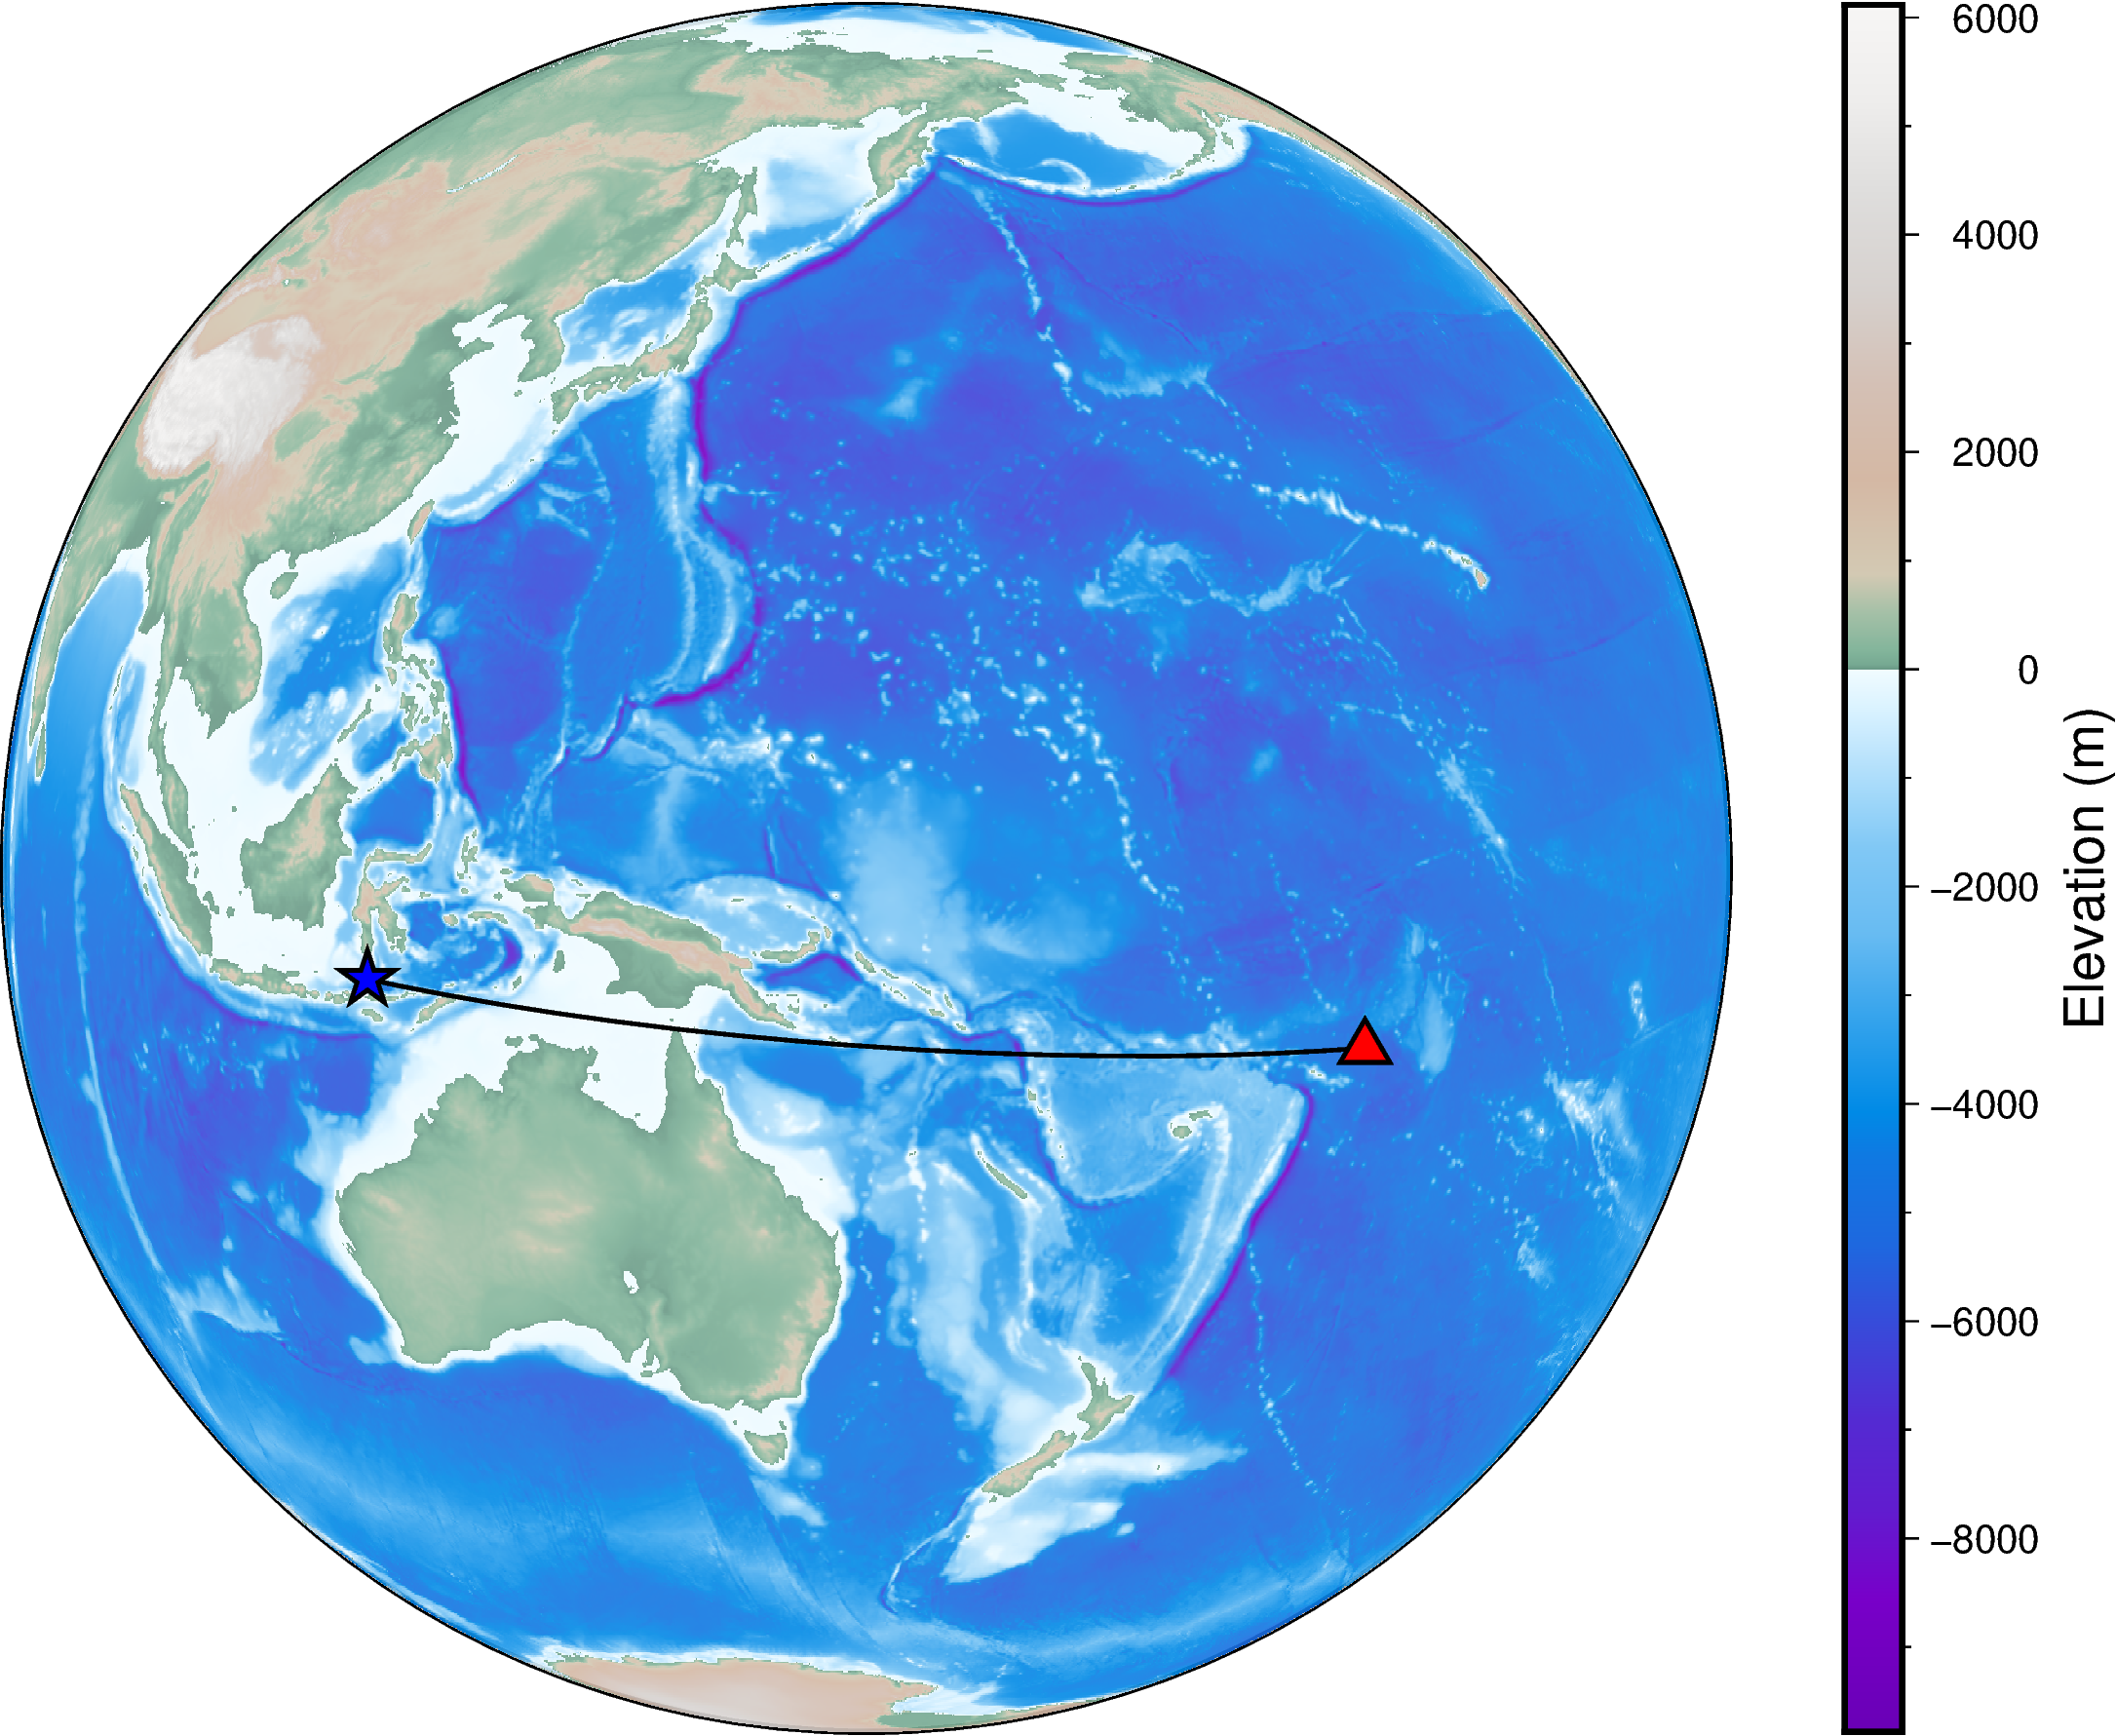

In [9]:
mapping.plot_station_event_geometry(event_lat, event_lon, station_lat, station_lon)

Now, to the bathymetry around the station. We will first get map extents around
the MERMAID and the event, the complete Mermaid track, and the local extent
around the MERMAID.

The local extent (`line_extent`) is computed using the +/- 10 km around the 
station along the backazimuth of the event.

The `mermaid.get_extent` function is getting the min/max latitude and longitude
of the Mermaid track.

The `mapping.get_extent` function is getting the min/max latitude and longitude
of the event and station location.

Finally, `mapping.fix_extent` is taking the found extent and expanind it by a
buffer of 5% and fixing the short end to create a 2 to 1 aspect ratio.


In [10]:

import specfempp.examples_utilities.mermaid as mermaid
import matplotlib.dates as mdates

# Get the extent of the mermaid track
mermaid_extent = mermaid.get_extent(mermaid_metadata)

# Fix the extent for ok map aspect ratio
mermaid_extent = mapping.fix_extent(mermaid_extent)

# Get the extent of the event and the station
event_station_extent = mapping.get_extent(event_lat, event_lon, station_lat, station_lon)

# Fix the extent for ok map aspect ratio
event_station_extent = mapping.fix_extent(event_station_extent)


The next step is defining the line around the Mermaid along which we want to 
extract the bathymetry. As defined in Ivy's paper the line is selected along the
backazimuth of the event and 10 km on either side of the station.

### Getting the line along which to interpolate the bathymetry

In [11]:
dist_in_m, az, baz = obspy.geodetics.gps2dist_azimuth(event_lat, event_lon, station_lat, station_lon)

# Define with 
width = 20000
npts = 501

# Get the line around the station
line_offset, line_latitudes, line_longitudes = \
    mapping.get_line(station_lat, station_lon,width, npts, baz)


In [12]:
# Get the line_extent
line_extent = mapping.get_extent(line_latitudes[0], line_longitudes[0],
                                  line_latitudes[-1], line_longitudes[-1])

# Fix the extent for ok map aspect ratio
line_extent = mapping.fix_extent(line_extent, fraction=0.2)

In [13]:
print(f"Line Extent: {line_extent}")
print(f"Line Longitudes: {line_longitudes[0]}, {line_longitudes[-1]}")
print(f"Line Latitudes: {line_latitudes[0]}, {line_latitudes[-1]}")

Line Extent: [np.float64(-168.44074152726733), np.float64(-168.3124594696831), np.float64(-12.03456676415771), np.float64(-11.970425735365588)]
Line Longitudes: -168.33078547790942, -168.422415519041
Line Latitudes: -11.999545162551568, -12.00544733697173


Now, before we map everything, let's extract the bathymetry around the mermaid
track for reference, and locally around the station to interpolate the
bathymetry along the line.

### Extracting bathymetry around the station

In [14]:
import specfempp.examples_utilities.gebco as gebco

# Download the bathymetry from GEBCO
gebco.download()

# Extract bathymetry for the mermaid extent
mermaid_bathymetry = gebco.get_bathymetry(mermaid_extent, split=False)

# Local bathymetry around the station
local_bathymetry = gebco.get_bathymetry(line_extent, split=False)

Bathymetry data already exists. Skipping download.


Now that we the bathymetry we can interpolate the line bathymetry using the
`scipy.interpolate.griddata` function.


### Interpolating the bathymetry along the line

In [ ]:
line_offset, line_bathymetry, line_latitudes, line_longitudes = \
    gebco.bathymetryprofile(
        width, npts, [station_lon, station_lat], baz, 
        input_lons=local_bathymetry['longitudes'], 
        input_lats=local_bathymetry['latitudes'], 
        input_bathy=local_bathymetry['elevation'])


Now that the bathymetry is interpolated, we can plot a summary map of the
bathymetry around the station and the event along with the Mermaid track.

### Plotting the bathymetry around the station and event

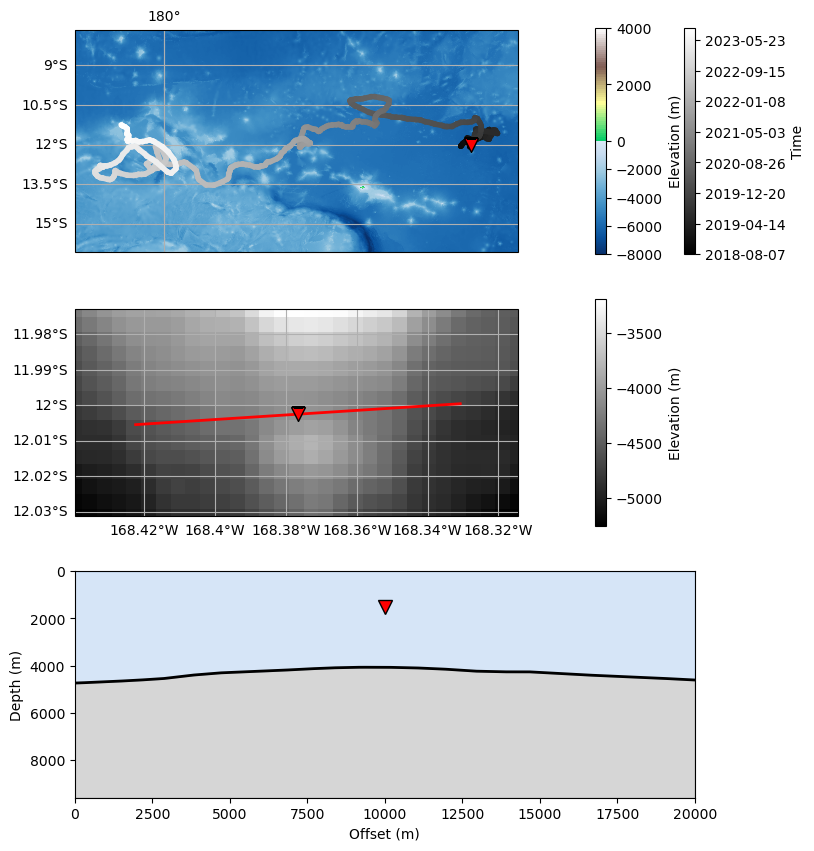

In [16]:
gebco.plot_summary(station_lat, station_lon, event_lat, event_lon,
                   mermaid_metadata,
                   mermaid_bathymetry, local_bathymetry, 
                   line_offset, line_bathymetry, 
                   line_latitudes, line_longitudes)


The final step before writing the necessary files and running the simulation is 
to compute the incidence angle of the plane wave impinging on the domain.


### Computing the incidence angle

In [12]:
import obspy.taup

# Use ak135 model
model = obspy.taup.TauPyModel(model="ak135")

# Get the travel times
arrivals = model.get_ray_paths(source_depth_in_km=event_depth/1000,
                               distance_in_degree=dist_in_m/1000/111.195,
                               phase_list=["P"])

# Get the incidence angle
incidence_angle = arrivals[0].incident_angle

print(f"Incidence Angle: {incidence_angle:.2f} degrees")

Incidence Angle: 17.88 degrees


## Running the simulation with SPECFEM++



Now that we have the bathymetry and the incidence angle, we can run the
simulation with SPECFEM++ since we are able to generate the mesh file, the
topography file, and create the sources to be generated.

The next step is to create the mesh parameter file by first reading a base
`Par_file` and updating the necessary parameters to adjust for size and
resolution of the mesh.

### Update Parameter file and Topography file

In [18]:
from specfempp.utilities import get_par_file, write_par_file

# Get the base par file
par_dict = get_par_file("Base_Par_file", verbose=False, savecomments=True)

par_dict["receiversets"]["nrec"], \
par_dict["receiversets"]["zdeb"], \
par_dict["receiversets"]["zfin"]

([1, 1], [8082.0, 5472.0], [8082.0, 5472.0])

In [ ]:
# Update the par file # make sure that bathymetry values are positive here!
gebco.update_par_file_extent(par_dict, line_offset[-1], 9600, 9600+line_bathymetry, verbose=True)

# Write the par file
write_par_file(par_dict, "Par_file", write_comments=True)

nx: 250, ny: 120, nlower: 54, nupper: 66


Next, we need to write the topography file, which is a simple ASCII file with
the bathymetry values at each point in the mesh.


In [15]:
gebco.write_topography_file("topography_file.dat", line_offset[-1], 9600, 9600+line_bathymetry, line_offset)

Finally, we can run the mesher.

In [20]:
from subprocess import call
from os import makedirs

### Running the mesher

In [21]:
# Create the output directory for the database files.
makedirs("OUTPUT_FILES/results", exist_ok=True)
call("xmeshfem2D -p Par_file", shell=True)


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to f8c66778e3bcff99be726113a1aca338255ed87e
 dating 2023-03-21 19:54:51 +0100

 Reading the parameter file...

 Title of the simulation: fluid-solid-bathymetry

 Receiver lines:
   Nb of line sets =            2

 Materials:
   Nb of solid, fluid or porous materials =            2

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2500.0000000000000        3400.0000000000000        1963.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #           2  isotropic
 rho,cp,cs   =    1020.0000000000000        1500.0000000000000        0.0000000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is fluid
 --------


 Mesh from internal meshing:

 Reading interface data from f

0

We setup the file to run the simulation.

In [17]:
from specfempp import Config

config = Config({
    "databases": {
        "mesh-database": "OUTPUT_FILES/database.bin"
    },
    "header": {
        "description": "Material systems : Elastic domain (1), Acoustic domain (1)\nInterfaces : Acoustic-elastic interface (1) (orientation horizontal with acoustic domain on top)\nSources : Moment-tensor (234)\nBoundary conditions : Neumann BCs on all edges\n",
        "title": "fluid-solid-bathymetry"
    },
    "receivers": {
        "angle": 0.0,
        "nstep_between_samples": 10,
        "seismogram-type": [
            "pressure"
        ],
        "stations": "OUTPUT_FILES/STATIONS"
    },
    "run-setup": {
        "number-of-processors": 1,
        "number-of-runs": 1
    },
    "simulation-setup": {
        "quadrature": {
            "quadrature-type": "GLL4"
        },
        "simulation-mode": {
            "forward": {
                "writer": {
                    "display": {
                        "directory": "OUTPUT_FILES/results",
                        "field": "displacement",
                        "format": "PNG",
                        "simulation-field": "forward",
                        "time-interval": 100
                    },
                    "seismogram": {
                        "directory": "OUTPUT_FILES/results",
                        "format": "ascii"
                    }
                }
            }
        },
        "solver": {
            "time-marching": {
                "time-scheme": {
                    "dt": 0.002,
                    "nstep": 5000,
                    "type": "Newmark"
                },
                "type-of-simulation": "forward"
            }
        }
    },
    "sources": "line_sources.yaml"
})

We use the `create_sources` function, which relies on the P wave velocity and
the incidence angle. to compute the sequentially firing points sources that form
a line source that is observed as a plane wave at the station.

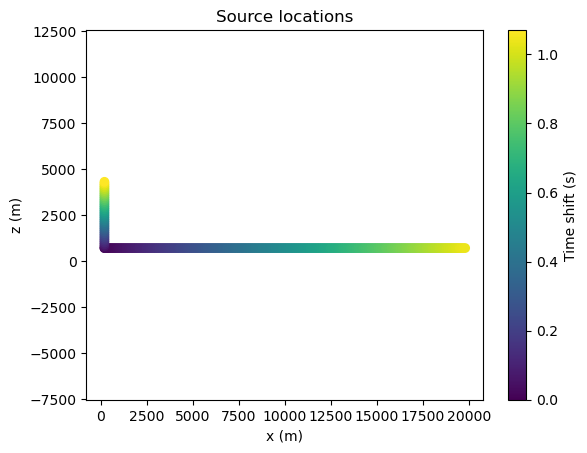

In [18]:
from specfempp.examples_utilities import sources

# Create source file
source_dict = sources.create_sources(incidence_angle, 3400, bathymetry_in_m=-line_bathymetry,
                                     bathymetry_offset_in_m=line_offset)


# Define the number of sources in x in z direction
number_of_sources_x = 197
number_of_sources_z = 37

# Define the source dictionary
source_dict = dict()
source_dict["number-of-sources"] = number_of_sources_x + number_of_sources_z
source_list = list()

# Append sources in x direction
for i in range(number_of_sources_x):
    moment_tensor = {"moment-tensor": dict()}
    moment_tensor["moment-tensor"]["x"] = 200.0 + i * 100.0
    moment_tensor["moment-tensor"]["z"] = 720.0
    moment_tensor["moment-tensor"]["Mxx"] = 1.0
    moment_tensor["moment-tensor"]["Mzz"] = 1.0
    moment_tensor["moment-tensor"]["Mxz"] = 0.0
    moment_tensor["moment-tensor"]["angle"] = 0.0
    moment_tensor["moment-tensor"]["Ricker"] = dict()
    moment_tensor["moment-tensor"]["Ricker"]["factor"] = 9.836e-10
    moment_tensor["moment-tensor"]["Ricker"]["tshift"] = 5.309e-03 * i
    moment_tensor["moment-tensor"]["Ricker"]["f0"] = 1.0
    source_list.append(moment_tensor)

# Append sources in z direction
for i in range(number_of_sources_z):
    moment_tensor = {"moment-tensor": dict()}
    moment_tensor["moment-tensor"]["x"] = 200.0
    moment_tensor["moment-tensor"]["z"] = 720.0 + i * 100.0
    moment_tensor["moment-tensor"]["Mxx"] = 1.0
    moment_tensor["moment-tensor"]["Mzz"] = 1.0
    moment_tensor["moment-tensor"]["Mxz"] = 0.0
    moment_tensor["moment-tensor"]["angle"] = 0.0
    moment_tensor["moment-tensor"]["Ricker"] = dict()
    moment_tensor["moment-tensor"]["Ricker"]["factor"] = 1.805e-10
    moment_tensor["moment-tensor"]["Ricker"]["tshift"] = 2.893e-02 * (i + 1)
    moment_tensor["moment-tensor"]["Ricker"]["f0"] = 1.0
    source_list.append(moment_tensor)

# Finally, we set the source-file parameter to the source dictionary
source_dict["sources"] = source_list
config.set_par("sources", source_dict)

# plot the source
sources.plot_sources(source_dict)

# Set the source in the config
config.set_par("sources", source_dict)


Now we add the receivers to the simulation.

In [19]:
receiver_list = list()
receiver1 = dict(network="AA", station="S0003", x=10000.0, z=8082.0)
receiver2 = dict(network="AA", station="S0004", x=10000.0, z=5472.0)
receiver_list.extend([receiver1, receiver2])

config.set_par("receivers.stations", receiver_list)


In [20]:
config.save_par("./test_config.yaml")

In [ ]:
from specfempp import execute

execute(config)

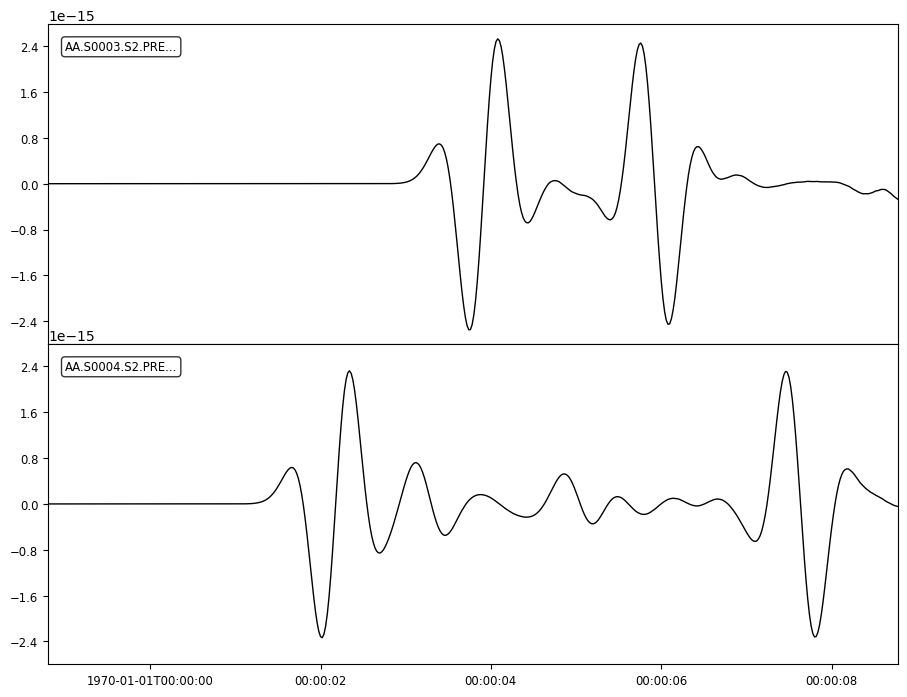

In [ ]:
import glob
import os
import numpy as np
import obspy
import matplotlib.pyplot as plt

def get_traces(directory):
    traces = []
    files = glob.glob(directory + "/*.sem*")
    ## iterate over all seismograms
    for filename in files:
        station_name = os.path.splitext(filename)[0]
        station_name = station_name.split("/")[-1]
        trace = np.loadtxt(filename, delimiter=" ")
        starttime = trace[0, 0]
        dt = trace[1, 0] - trace[0, 0]
        traces.append(
            obspy.Trace(
                trace[:, 1],
                {"network": station_name, "starttime": starttime, "delta": dt},
            )
        )

    stream = obspy.Stream(traces)

    return stream


stream = get_traces("OUTPUT_FILES/results")
fig = plt.figure(figsize=(10, 8))
stream.plot(fig=fig)
plt.show()

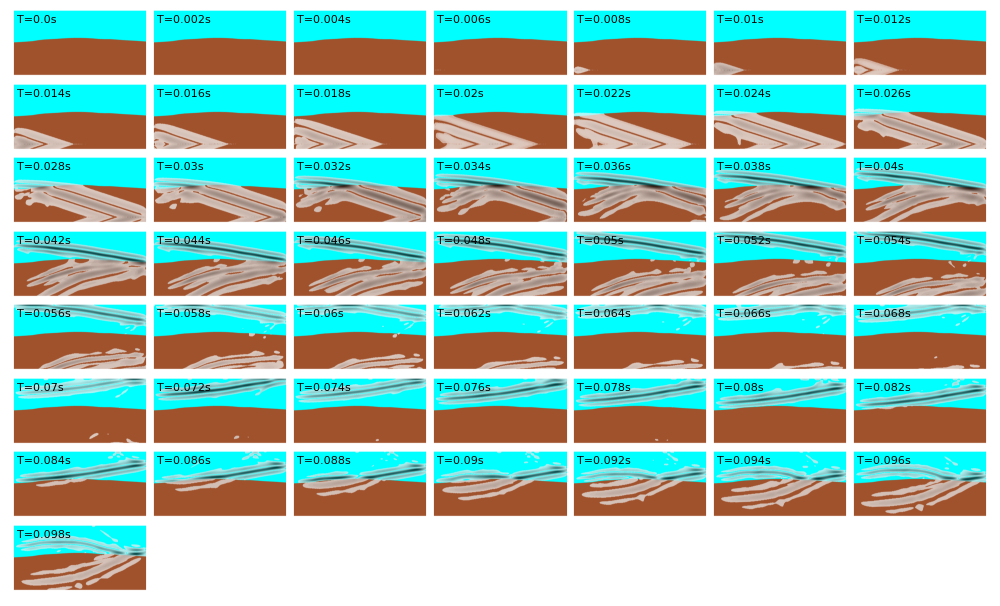

In [34]:
from specfempp.examples_utilities import plot
dt = config.get_par('simulation-setup.solver.time-marching.time-scheme.dt')
plot.plot_snapshots("OUTPUT_FILES/results", dt)